In [6]:
import numpy as np
import tensorflow as tf
from utils.DeepAnt import DeepAnt
from utils.WindowGen import WindowGenerator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from utils.get_UCR_anomaly import get_UCR_anomaly
import numpy as np

%matplotlib inline

UCR_182_qtdbSel1005V 4000 [12400, 12800]


TypeError: cannot unpack non-iterable int object

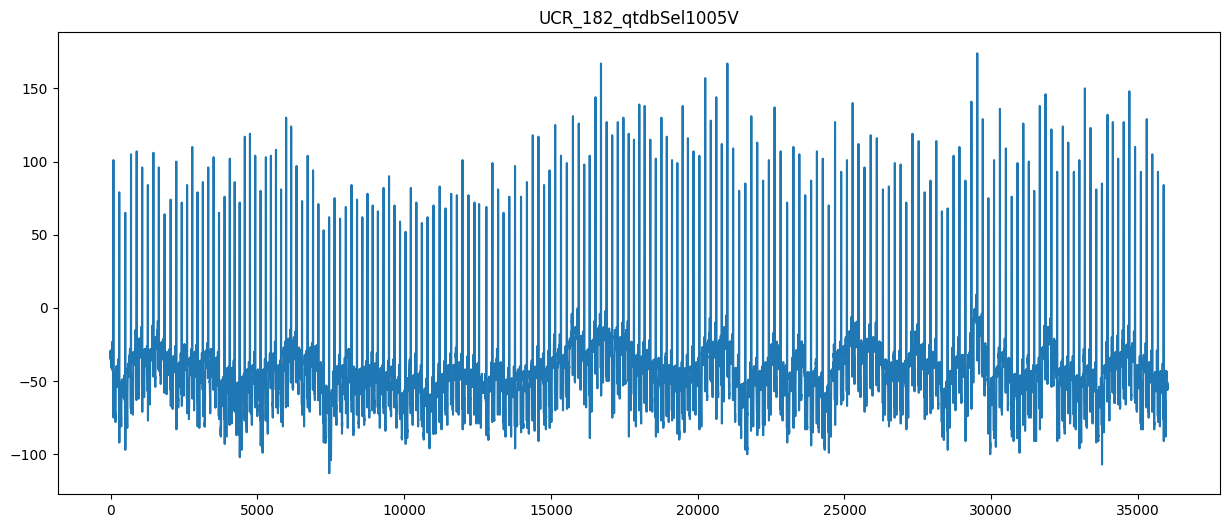

In [9]:
#df = pd.read_csv('data/TravelTime_451.csv', index_col = 'timestamp', parse_dates=['timestamp'])
path = '/Users/Okano700/Documents/GitHub/metaFeaturesTS/data/UCR_Anomaly_FullData/182_UCR_Anomaly_qtdbSel1005V_4000_12400_12800.txt'

#'/home/emerson/data/UCR_anomaly_dataset/204_UCR_Anomaly_CHARISfive_12412_15000_15070.txt'
#'/Users/Okano700/Documents/GitHub/metaFeaturesTS/data/UCR_Anomaly_FullData/182_UCR_Anomaly_qtdbSel1005V_4000_12400_12800.txt'


#'/Users/Okano700/Documents/GitHub/metaFeaturesTS/data/UCR_Anomaly_FullData/222_UCR_Anomaly_mit14046longtermecg_56123_91200_91700.txt'
#'/Users/Okano700/Documents/GitHub/metaFeaturesTS/data/UCR_Anomaly_FullData/152_UCR_Anomaly_PowerDemand1_9000_18485_18821.txt'
#'/Users/Okano700/Documents/GitHub/metaFeaturesTS/data/UCR_Anomaly_FullData/120_UCR_Anomaly_ECG2_15000_16000_16100.txt'


split_name = str(path).split('/')[-1]
split_name = str(split_name).split('.')[0]
name_aux = str(split_name).split('_')
ds_name = f"{name_aux[1]}_{name_aux[0]}_{name_aux[3]}"
m_v = int(name_aux[4])
an = [int(name_aux[5]), int(name_aux[6])]
print(ds_name, m_v, an)



df_1 = np.genfromtxt(path)
df = pd.DataFrame(df_1,columns=['value'])
df.plot(figsize = (15, 6), title = ds_name, legend = False);
start, end, m_v = get_UCR_anomaly(df, path)
#y_ = np.zeros(len(df))
#y_[an[0]:an[1]] =1
#df['anomaly'] = y_
plt.plot()

In [10]:
df

,value,anomaly
0,-32.0,0.0
1,-30.0,0.0
2,-33.0,0.0
3,-34.0,0.0
4,-32.0,0.0
...,...,...
35996,-51.0,0.0
35997,-51.0,0.0
35998,-52.0,0.0
35999,-56.0,0.0


In [34]:
from scipy.signal import periodogram
from math import floor
f, px = periodogram(np.array(df)[:,0], detrend='linear')
floor(1/f[np.argmax(px)] + 0.5)
n = 10
ind = np.argpartition(px, -n)[-n:]


print([floor(1/f[a] + 0.5) for a in px.argsort()[-n:][::-1]])
print([f[a] for a in px.argsort()[-n:][::-1]])

[12000, 2400, 4500, 18001, 2769, 5143, 193, 2250, 9000, 36001]
[8.333101858281715e-05, 0.0004166550929140857, 0.00022221604955417905, 5.555401238854476e-05, 0.00036110108052554094, 0.00019443904335990667, 0.005194300158328936, 0.0004444320991083581, 0.00011110802477708953, 2.777700619427238e-05]


In [38]:
w_l = 193*2
p_w = 1

In [39]:
ds = WindowGenerator(input_width= w_l, label_width= p_w, shift = 1, train_df = df['value'].loc[:m_v].to_frame(), test_df = df['value'].to_frame(), val_df = df['value'].loc[:m_v].to_frame())

2023-10-19 16:14:47.871188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [4001,1]
	 [[{{node Placeholder/_0}}]]
2023-10-19 16:14:47.872008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [3615]
	 [[{{node Placeholder/_8}}]]


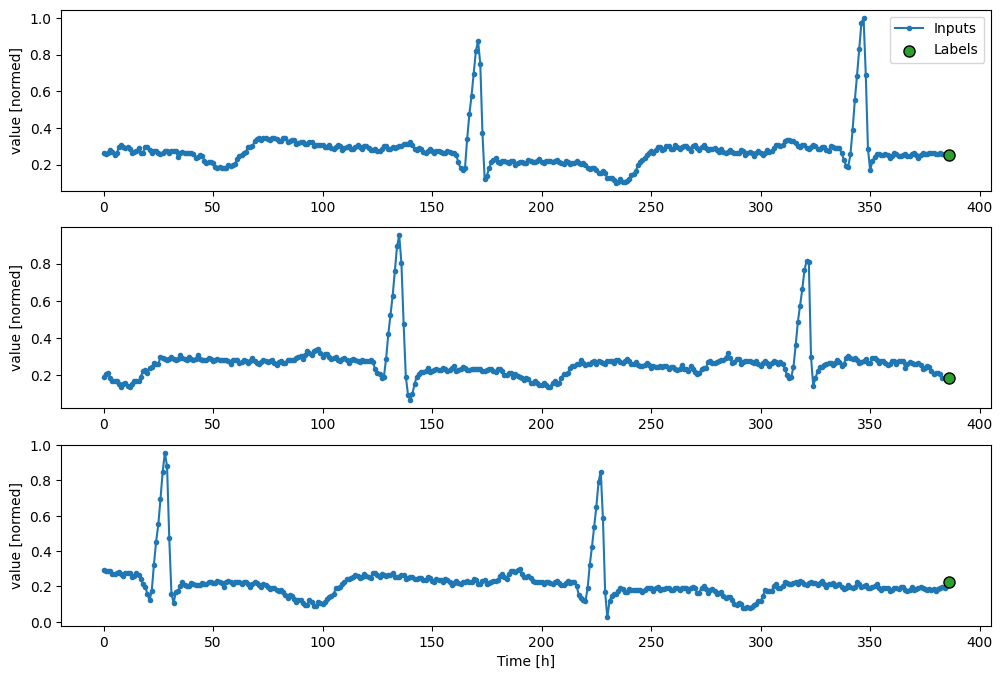

In [40]:
ds.plot(plot_col='value')

In [15]:
ds.make_dataset(df['value'].to_frame())

<_MapDataset element_spec=(TensorSpec(shape=(None, 132, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

In [16]:
DA = DeepAnt(w_l = w_l)

In [17]:
def compile_and_fit(model, window,MAX_EPOCHS = 30, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    checkpoint_filepath = 'tmp/checkpoint'

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping,model_checkpoint_callback], verbose = 0)
    return history

In [23]:
ds.train


<_MapDataset element_spec=(TensorSpec(shape=(None, 132, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

In [21]:
hist = compile_and_fit(DA, ds, patience =10, MAX_EPOCHS = 50)

#DA.load_weights('tmp/checkpoint')

2023-10-19 13:54:32.757670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [4001,1]
	 [[{{node Placeholder/_0}}]]
2023-10-19 13:54:32.758598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [4001,1]
	 [[{{node Placeholder/_0}}]]


TypeError: this __dict__ descriptor does not support '_DictWrapper' objects

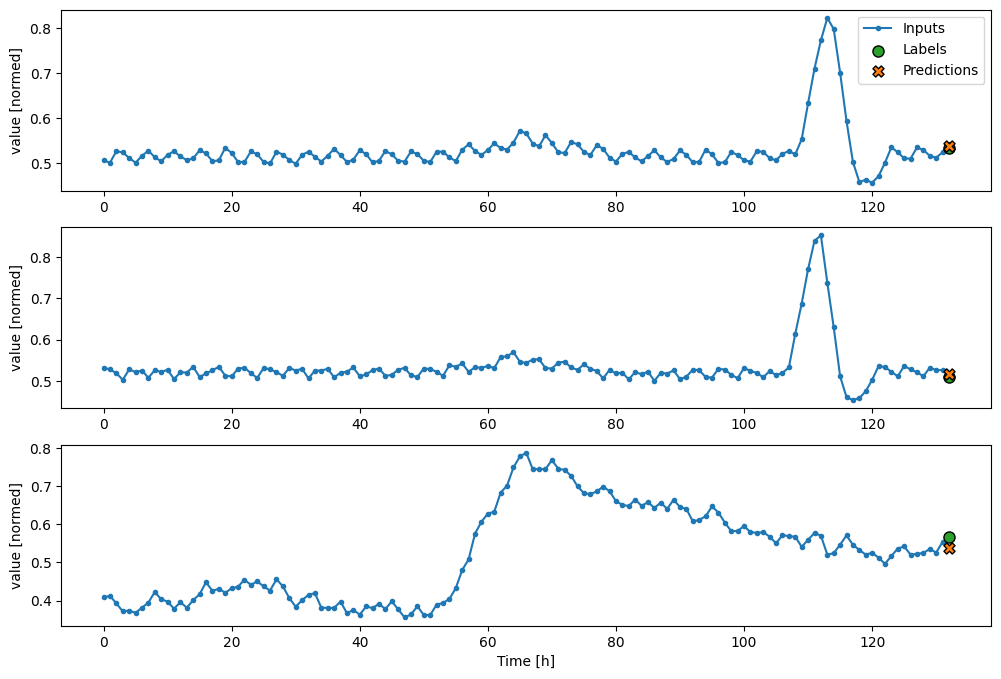

In [34]:
ds.plot(DA, plot_col='value')

In [20]:
ds

Total window size: 133
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131]
Label indices: [132]
Label column name(s): None

In [35]:
a =ds.make_ds_pred(data = df['value'].to_frame())

In [36]:
#loss_ = []
#for X,y in a.as_numpy_iterator(): 
#    loss_.append(np.squeeze(np.abs(y- DA.predict(X))))

In [37]:
yhat, loss = DA.get_loss(a)
preds_losses = pd.Series(loss, index = np.arange(w_l,len(df)))

91868/91868 [==============================] - 136s 1ms/step


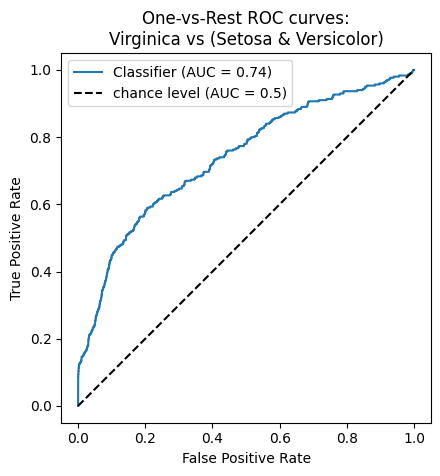

In [38]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay
RocCurveDisplay.from_predictions(df['anomaly'].iloc[preds_losses.index.min():], preds_losses)
#plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
#display.plot()

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [39]:
def plot_predictions(preds, threshold, bins = 80):
    sns.displot(preds, bins = bins, kde = True, height = 8, aspect = 2)
    plt.axvline(x = threshold, color = 'r', linestyle = '--', label = 'Chosen Threshold')
    plt.title('Loss Distribution')
    plt.legend()

def loss_plot(preds, threshold):
    preds.plot(figsize = (15,8), title = 'Chosen Threshold', label = 'Loss')
    plt.axhline(y = threshold, color = 'r', linestyle = '--', label = 'Chosen Threshold')
    plt.legend()
    plt.show();

def ts_plot(df, preds, threshold, alg = 'DeepAnT', range = None):
    idx = preds.loc[lambda x: x > threshold].index
    plt.figure(figsize = (20,8))
    if range is not None:
        min, max = range
        df = df[min:max]
    plt.plot(df, label = '_nolegend_')
    plt.scatter(idx, df.loc[idx], color = 'red', label = 'Detected Anomalies by DeepAnt')
    plt.title('Detected Anomalies in Time Series')
    plt.legend()
    plt.show();

In [ ]:
THRESHOLD = 0.35
plot_predictions(preds_losses, THRESHOLD)

In [ ]:
loss_plot(preds_losses, 0.4)

In [ ]:
ts_plot(df['value'], preds_losses, 0.15)

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(yhat.reshape(-1,1))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit_transform(df['value'].values.reshape(-1,1))

In [ ]:
np.array(df['value'].to_frame())

In [ ]:
idx = preds_losses.loc[lambda x: x > 0.5].index

In [ ]:
idx

In [ ]:
len(df)

In [ ]:
np.zeros(len(df))